# Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random

In [2]:
with open('ids_to_genres.json', 'r') as f:
    ids_to_genres = json.load(f)

# Analysis

## Genre analysis

In [3]:
num_found_genres = len([song_id for song_id in ids_to_genres if ids_to_genres[song_id]])
print(f"The matching algorithm has retrieved {num_found_genres} songs with (at least) an attached genre.")

The matching algorithm has retrieved 36334 songs with (at least) an attached genre.


Create a matching genre -> number of instances of that genre.

In [4]:
genres = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    for genre in genres_for_song:
        if genre in genres:
            genres[genre] += 1
        else:
            genres[genre] = 1

In [5]:
num_unique_genres    = len(genres)
max_songs_per_genre  = max([int(x) for x in genres.values()])
most_frequent_genre  = max(genres.keys(), key=lambda x: genres[x])
min_songs_per_genre  = min([int(x) for x in genres.values()])
num_of_min_songs     = sum([1 for x in genres.values() if x == min_songs_per_genre])
mean_songs_per_genre = np.average([int(x) for x in genres.values()])
std_songs_per_genre  = np.std([int(x) for x in genres.values()])

print(f"There are {num_unique_genres} distinct genres in the dataset.")
print(f"Each genre has an average of {mean_songs_per_genre:.4f} songs, with a standard "
      f"deviation of {std_songs_per_genre:.3f}.")
print(f"The genre which is assigned to the highest number of songs ({max_songs_per_genre}) "
      f"is {most_frequent_genre}, while the minimum is {min_songs_per_genre}.")
print(f"Some examples of the {num_of_min_songs} genres matched to only {min_songs_per_genre} songs: "
      f"{random.choices([g for g in genres.keys() if genres[g] == min_songs_per_genre], k=5)}.")



There are 2146 distinct genres in the dataset.
Each genre has an average of 64.3448 songs, with a standard deviation of 267.226.
The genre which is assigned to the highest number of songs (4860) is rock, while the minimum is 1.
Some examples of the 317 genres matched to only 1 songs: ['azontobeats', 'jangle rock', 'gothic post-punk', 'deep funk house', 'orebro indie'].


In [6]:
most_frequent_ordered_genre_names = sorted(
    [genre_name for genre_name in genres], 
    key=lambda g: -genres[g]
)

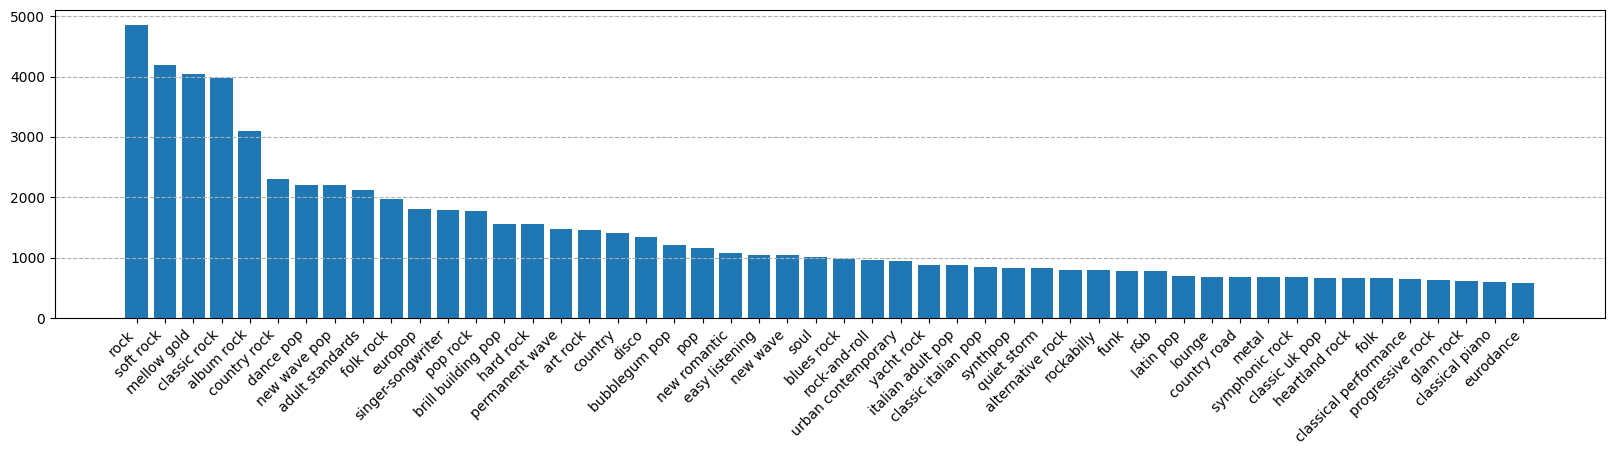

In [7]:
TOP_N = 50
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(most_frequent_ordered_genre_names[:TOP_N], 
        [genres[g] for g in most_frequent_ordered_genre_names[:TOP_N]])
plt.xticks(rotation=45, ha='right');
plt.grid(axis='y', linestyle='--')

## Subgenre analysis

What if we group together some genres composed by multiple words?

In [8]:
grouped_genres = {}

for song_id in ids_to_genres:
    genres_for_song = ids_to_genres[song_id]
    for genre in genres_for_song:
        subgenres = re.split(r"-| |,", genre)
        for subgenre in subgenres:
            if subgenre in grouped_genres:
                grouped_genres[subgenre] += 1
            else:
                grouped_genres[subgenre] = 1

In [9]:
num_unique_grouped_genres    = len(grouped_genres)
max_songs_per_grouped_genre  = max([int(x) for x in grouped_genres.values()])
most_frequent_grouped_genre  = max(grouped_genres.keys(), key=lambda x: grouped_genres[x])
min_songs_per_grouped_genre  = min([int(x) for x in grouped_genres.values()])
num_of_grouped_min_songs     = sum([1 for x in grouped_genres.values() if x == min_songs_per_genre])
mean_songs_per_grouped_genre = np.average([int(x) for x in grouped_genres.values()])
std_songs_per_grouped_genre  = np.std([int(x) for x in grouped_genres.values()])

print(f"There are {num_unique_grouped_genres} distinct subgenres in the dataset.")
print(f"Each subgenre has an average of {mean_songs_per_grouped_genre:.4f} songs, with a standard "
      f"deviation of {std_songs_per_grouped_genre:.3f}.")
print(f"The subgenre which is assigned to the highest number of songs ({max_songs_per_grouped_genre}) "
      f"is {most_frequent_grouped_genre}, while the minimum is {min_songs_per_grouped_genre}.")
print(f"Some examples of the {num_of_grouped_min_songs} subgenres matched to only {min_songs_per_grouped_genre} songs: "
      f"{random.choices([g for g in grouped_genres.keys() if grouped_genres[g] == min_songs_per_grouped_genre], k=5)}.")



There are 1234 distinct subgenres in the dataset.
Each subgenre has an average of 212.0389 songs, with a standard deviation of 1401.415.
The subgenre which is assigned to the highest number of songs (39383) is rock, while the minimum is 1.
Some examples of the 145 subgenres matched to only 1 songs: ['indigena', 'nightrun', 'electronics', 'jovem', 'yoik'].


In [10]:
most_frequent_ordered_grouped_genre_names = sorted(
    [genre_name for genre_name in grouped_genres], 
    key=lambda g: -grouped_genres[g]
)

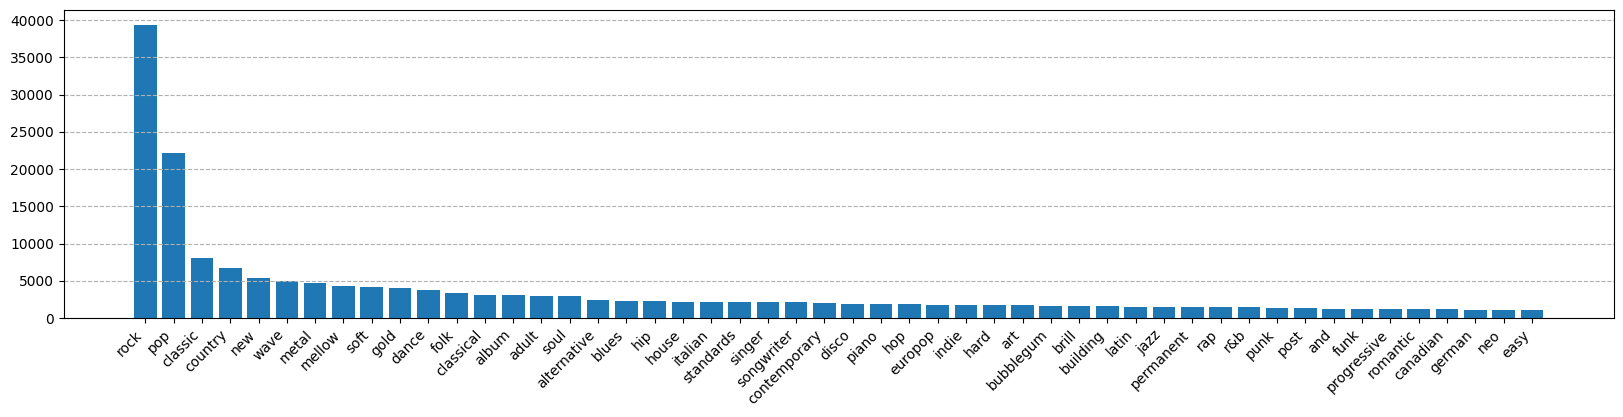

In [11]:
TOP_N = 50
fig, ax = plt.subplots(figsize=(20,4))
plt.bar(most_frequent_ordered_grouped_genre_names[:TOP_N], 
        [grouped_genres[g] for g in most_frequent_ordered_grouped_genre_names[:TOP_N]])
plt.xticks(rotation=45, ha='right');
plt.grid(axis='y', linestyle='--')

There are some interesting subgenres in the top-100 of this new list, like:
- rock
- pop
- classic
- country
- metal
- classical
- folk
- blues
- house
- soul
- indie
- latin
- jazz
- rap
- punk
- r&b
- psychedelic
- gospel
- electronic